In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
df = pd.read_csv("alltracks.csv", index_col=0)

In [49]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
0,Untouched,SilenCee,Untouched,"07 Dec 2022, 09:30",1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
1,maria,Malte,maria,"07 Dec 2022, 09:18",1670404731,https://www.last.fm/music/Malte/_/maria,german
2,let me go,Malte,let me go,"07 Dec 2022, 09:16",1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
3,So What,mqx,So What,"07 Dec 2022, 09:14",1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
4,maria,Malte,maria,"07 Dec 2022, 09:11",1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...,...
17686,The Tower,Future Islands,People Who Aren’t There Anymore,"17 Jul 2024, 12:51",1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
17687,King of Sweden,Future Islands,People Who Aren’t There Anymore,"17 Jul 2024, 12:47",1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
17688,Svefn-g-englar,Sigur Rós,Ágætis byrjun,"17 Jul 2024, 12:41",1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock
17689,Svefn-g-englar,Sigur Rós,Ágætis byrjun,"17 Jul 2024, 11:46",1721216760,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


In [50]:
index_to_delete = df[df['tags'] == '[]'].index
df.drop(index_to_delete, inplace=True)

In [51]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
0,Untouched,SilenCee,Untouched,"07 Dec 2022, 09:30",1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
1,maria,Malte,maria,"07 Dec 2022, 09:18",1670404731,https://www.last.fm/music/Malte/_/maria,german
2,let me go,Malte,let me go,"07 Dec 2022, 09:16",1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
3,So What,mqx,So What,"07 Dec 2022, 09:14",1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
4,maria,Malte,maria,"07 Dec 2022, 09:11",1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...,...
17686,The Tower,Future Islands,People Who Aren’t There Anymore,"17 Jul 2024, 12:51",1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
17687,King of Sweden,Future Islands,People Who Aren’t There Anymore,"17 Jul 2024, 12:47",1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
17688,Svefn-g-englar,Sigur Rós,Ágætis byrjun,"17 Jul 2024, 12:41",1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock
17689,Svefn-g-englar,Sigur Rós,Ágætis byrjun,"17 Jul 2024, 11:46",1721216760,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


Check for null values and inspect the data

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17362 entries, 0 to 17690
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_name     17362 non-null  object
 1   artist         17362 non-null  object
 2   album_name     17362 non-null  object
 3   date_listened  17362 non-null  object
 4   uts            17362 non-null  int64 
 5   url            17362 non-null  object
 6   tags           17362 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [53]:
df.isnull().sum()

,0
track_name,0
artist,0
album_name,0
date_listened,0
uts,0
url,0
tags,0


In [54]:
df['artist'].value_counts()

,count
artist,
Radiohead,2353
The Strokes,403
The Smile,374
JPEGMAFIA,319
Talking Heads,300
...,...
Mark Farina,1
Sampology,1
Ladi6,1


In [55]:
artist_counts = df.groupby('artist').agg({
    'track_name': 'count',
    'tags': 'first'
}).reset_index()
artist_counts.rename(columns={'track_name': 'count'}, inplace=True)

artist_counts

,artist,count,tags
0,!!!,2,seen live
1,100 gecs,7,hyperpop
2,1999 WRITE THE FUTURE,1,rap
3,21 Savage,3,trap
4,2562,3,dubstep
...,...,...,...
1242,ДЕТИ RAVE,2,Rave
1243,万能青年旅店,1,rock
1244,久石譲,48,Soundtrack
1245,光良,1,chinese


In [56]:
artist_counts = artist_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
artist_counts

top_10_artists = artist_counts[artist_counts.index < 10]
top_10_artists

,artist,count,tags
0,Radiohead,2353,alternative
1,The Strokes,403,indie rock
2,The Smile,374,post-punk
3,JPEGMAFIA,319,Hip-Hop
4,Talking Heads,300,new wave
5,Malte,299,german
6,Tame Impala,276,Psychedelic Rock
7,LCD Soundsystem,267,electronic
8,Frank Ocean,262,rnb
9,King Gizzard & The Lizard Wizard,233,Psychedelic Rock


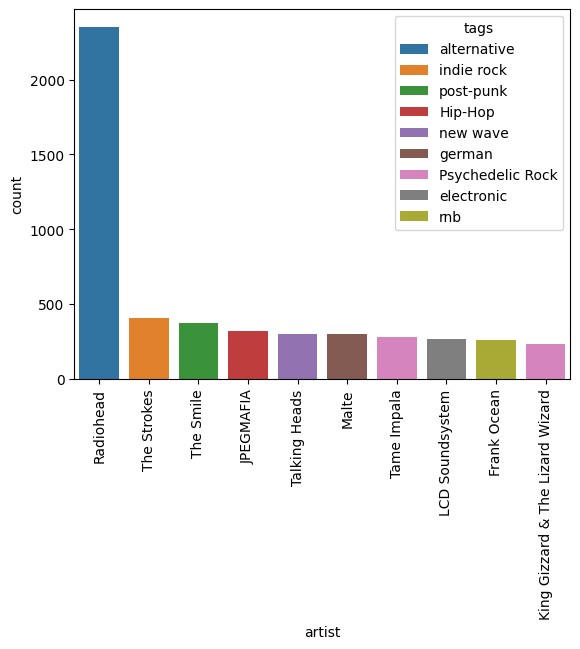

In [57]:
sns.barplot(top_10_artists, x='artist', y='count', hue='tags');
plt.xticks(rotation=90);

In [58]:
df['date_listened'] = pd.to_datetime(df['date_listened'])

In [59]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
0,Untouched,SilenCee,Untouched,2022-12-07 09:30:00,1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
1,maria,Malte,maria,2022-12-07 09:18:00,1670404731,https://www.last.fm/music/Malte/_/maria,german
2,let me go,Malte,let me go,2022-12-07 09:16:00,1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
3,So What,mqx,So What,2022-12-07 09:14:00,1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
4,maria,Malte,maria,2022-12-07 09:11:00,1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...,...
17686,The Tower,Future Islands,People Who Aren’t There Anymore,2024-07-17 12:51:00,1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
17687,King of Sweden,Future Islands,People Who Aren’t There Anymore,2024-07-17 12:47:00,1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
17688,Svefn-g-englar,Sigur Rós,Ágætis byrjun,2024-07-17 12:41:00,1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock
17689,Svefn-g-englar,Sigur Rós,Ágætis byrjun,2024-07-17 11:46:00,1721216760,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


In [60]:
df.set_index('date_listened', inplace=True)

In [61]:
df

,track_name,artist,album_name,uts,url,tags
date_listened,,,,,,
2022-12-07 09:30:00,Untouched,SilenCee,Untouched,1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
2022-12-07 09:18:00,maria,Malte,maria,1670404731,https://www.last.fm/music/Malte/_/maria,german
2022-12-07 09:16:00,let me go,Malte,let me go,1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
2022-12-07 09:14:00,So What,mqx,So What,1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
2022-12-07 09:11:00,maria,Malte,maria,1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...
2024-07-17 12:51:00,The Tower,Future Islands,People Who Aren’t There Anymore,1721220684,https://www.last.fm/music/Future+Islands/_/The...,seen live
2024-07-17 12:47:00,King of Sweden,Future Islands,People Who Aren’t There Anymore,1721220434,https://www.last.fm/music/Future+Islands/_/Kin...,seen live
2024-07-17 12:41:00,Svefn-g-englar,Sigur Rós,Ágætis byrjun,1721220115,https://www.last.fm/music/Sigur+R%C3%B3s/_/Sve...,post-rock


In [62]:
monthly_counts = df['track_name'].resample('M').count()

monthly_counts = monthly_counts.reset_index()

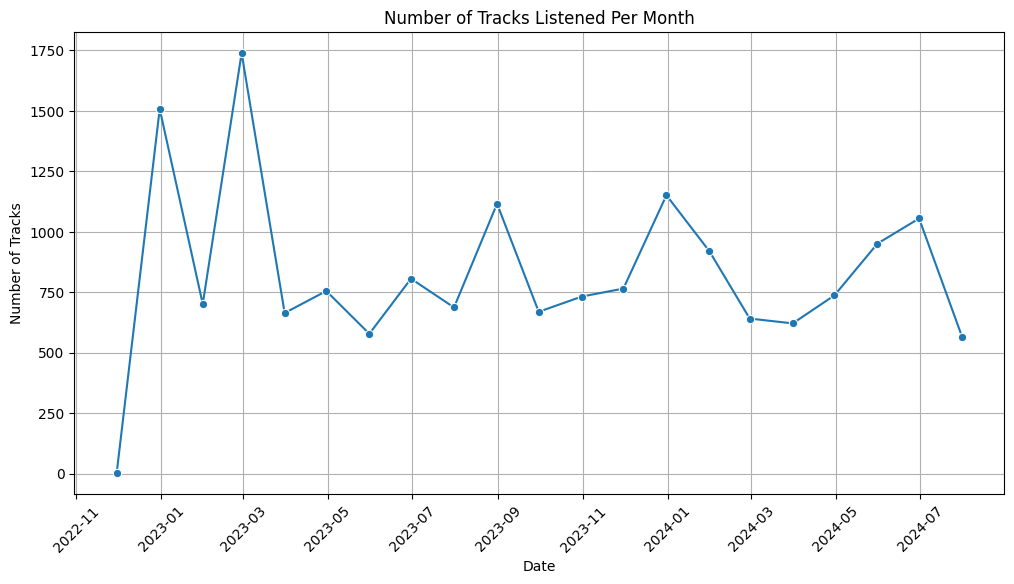

In [63]:
# Plot the data using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='date_listened', y='track_name', marker='o')
plt.title('Number of Tracks Listened Per Month')
plt.xlabel('Date')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [64]:
df = df.reset_index()

In [65]:
df['session_id'] = (df['date_listened'].diff() > pd.Timedelta(minutes=1)).cumsum()
df['track_name_artist'] = df['track_name'] + ' - ' + df['artist']

In [66]:
unique_songs = df['track_name_artist'].unique()
unique_ids = list(range(1, len(unique_songs) + 1))
np.random.shuffle(unique_ids)
song_id = {song: unique_ids[i] for i, song in enumerate(unique_songs)}
id_song = {unique_ids[i]: song for i, song in enumerate(unique_songs)}


In [67]:
song_sequences = []
next_songs = []
for session_id, group in df.groupby('session_id'):
    songs = group['track_name_artist'].tolist()
    for i in range(1,len(songs)):
        sequence_ids = []
        prev_song_id = None
        for index, song in enumerate(songs[:i]):
            current_song_id = song_id[song]
            if current_song_id != prev_song_id:
                sequence_ids.append(current_song_id)
                prev_song_id = current_song_id
        next_song_id = song_id[songs[i]]
        song_sequences.append(sequence_ids)
        next_songs.append(next_song_id)

song_lengths = [len(x) for x in song_sequences]

In [68]:
from sklearn.model_selection import train_test_split
train_sequences, val_sequences, train_targets, val_targets, train_lengths, val_lengths = train_test_split(song_sequences, next_songs, song_lengths, test_size=0.2, random_state=42)


In [69]:
def collate_fn(batch):
    sequences, targets, lengths = zip(*batch)
    sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    targets = torch.stack(targets)
    lengths = torch.tensor(lengths)
    return sequences, targets, lengths

class Songdataset(Dataset):
    def __init__(self, sequences, targets, lengths):
        self.sequences = sequences
        self.targets = targets
        self.lengths = lengths

    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        return (torch.tensor(self.sequences[index]), torch.tensor(self.targets[index]), self.lengths[index])

train_dataset = Songdataset(train_sequences, train_targets, train_lengths)
test_dataset = Songdataset(val_sequences, val_targets, val_lengths)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True, collate_fn=collate_fn)

In [70]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # layer, batch size hidden size
        packed_out, _ = self.rnn(packed_input, h0)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out


In [71]:
import torch.optim as optim
input_size = 1
hidden_size = 512
output_size = len(song_id) + 1
num_layers = 1
model = RNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [72]:
num_epochs = 20
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets, lengths) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device).to(torch.float32), targets.to(device).to(torch.long)
        inputs = inputs.unsqueeze(2)
        lengths = lengths.cpu()
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward() # calculates gradients
        optimizer.step()  # updates parameters
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print("finished")


Epoch [1/20], Loss: 8.6834
Epoch [2/20], Loss: 8.5245
Epoch [3/20], Loss: 8.4579
Epoch [4/20], Loss: 8.4150
Epoch [5/20], Loss: 8.3659
Epoch [6/20], Loss: 8.3355
Epoch [7/20], Loss: 8.3109
Epoch [8/20], Loss: 8.2762
Epoch [9/20], Loss: 8.2601
Epoch [10/20], Loss: 8.2389
Epoch [11/20], Loss: 8.2240
Epoch [12/20], Loss: 8.2069
Epoch [13/20], Loss: 8.1870
Epoch [14/20], Loss: 8.1736
Epoch [15/20], Loss: 8.1648
Epoch [16/20], Loss: 8.1610
Epoch [17/20], Loss: 8.1548
Epoch [18/20], Loss: 8.1455
Epoch [19/20], Loss: 8.1353
Epoch [20/20], Loss: 8.1322
finished


<Axes: >

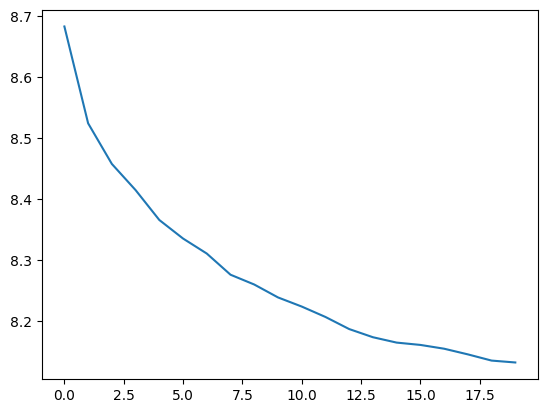

In [73]:
sns.lineplot(epoch_losses)

In [74]:
torch.save(model.state_dict(), 'model_weights.pth')